In [6]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join
from scipy.io import wavfile

import IPython.display as ipd
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim

# plotting utilities
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.titleweight"] = 'bold' 
plt.rcParams["figure.titlesize"] = 'large'
plt.rcParams['figure.dpi'] = 120
plt.style.use('fivethirtyeight')

rs = 99

In [10]:
files = 'recordings/'
ds_files = listdir(files)

X = []
y = []
for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    X.append(data.astype(np.float16))
    y.append(label)
    

In [11]:
print(len(X), len(y))

3000 3000


## Basic EDA

In [12]:
np.unique(y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([300, 300, 300, 300, 300, 300, 300, 300, 300, 300]))

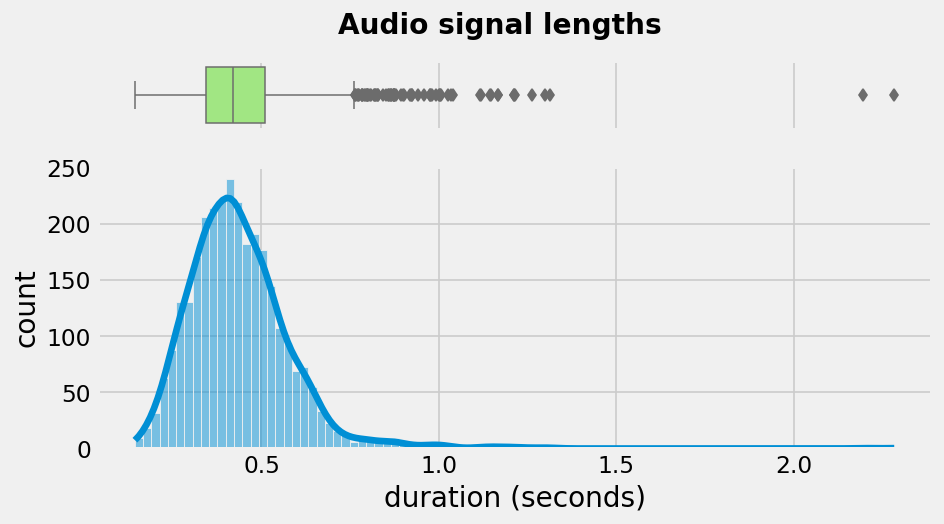

In [13]:
rate = 8000
def show_length_distribution(signals, rate = 8000):
    sampel_times = [len(x)/rate for x in signals]


    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})

    # Add a graph in each part
    sns.boxplot(x = sampel_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sampel_times, ax=ax_hist, bins = 'fd', kde = True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')


    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return sampel_times


lengths = show_length_distribution(X)

In [14]:
q = 90
np.percentile(lengths, q)

0.604525

In [15]:
tot_outliers = sum(map(lambda x: x > np.percentile(lengths, q), lengths))
print(f'Values outside {q} percentile: {tot_outliers}')

Values outside 90 percentile: 300


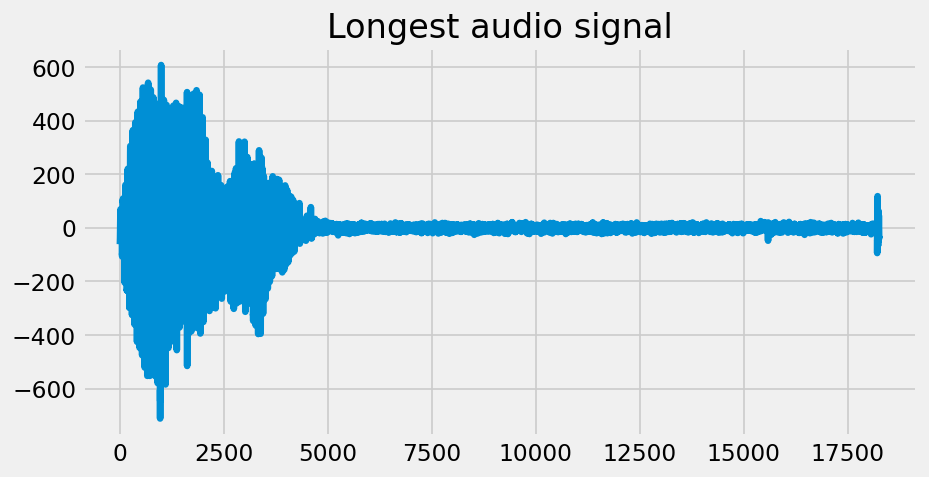

In [16]:
Longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[Longest_audio])
plt.title("Longest audio signal");


ipd.Audio(X[Longest_audio], rate=rate)

In [ ]:
Shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[Shortest_audio])
plt.title("Shortest audio signal");

ipd.Audio(X[Shortest_audio], rate=rate)

## Time domain analysis

### Feature Extraction from time domain

In [17]:
# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

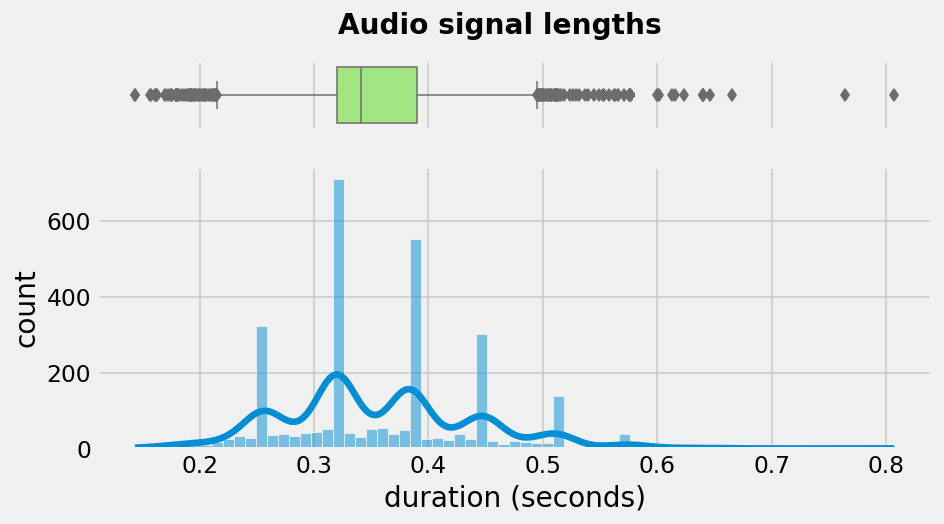

In [18]:
X_tr = [remove_silence(x) for x in X]

show_length_distribution(X_tr);

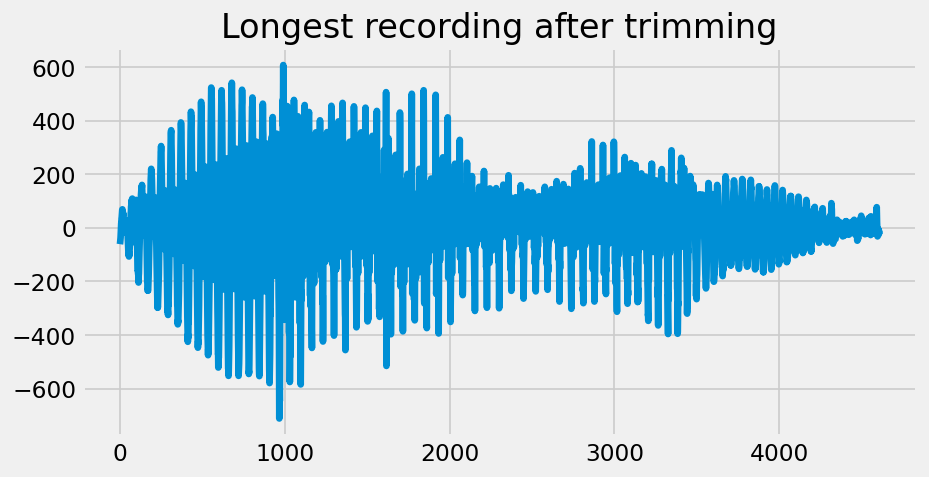

In [19]:
plt.plot(X_tr[Longest_audio])
plt.title("Longest recording after trimming");


ipd.Audio(X_tr[Longest_audio], rate=rate)

In [20]:
N = int(rate * 0.8) # 0.8 is the upper limit of trimmed audio length
X_uniform = []
for x in X_tr:
    if len(x) < N:
        X_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))
    else:
        X_uniform.append(x[:N])

In [21]:
def into_bins(X, bins = 20):
    """This functions creates bins of same width and computes mean and standard deviation on those bins
    """
    X_mean_sd = []
    for x in X:
        x_mean_sd = []
        As = np.array_split(np.array(x), 20)
        for a in As:
            mean = np.round(a.mean(dtype=np.float64), 4)
            sd = np.round(a.std(dtype=np.float64), 4)
            x_mean_sd.extend([mean, sd])

        X_mean_sd.append(x_mean_sd)
    return np.array(X_mean_sd)

### Model Building

In [22]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [23]:
for bins in range(20,101,20):
    X_mean_sd = into_bins(X_uniform, bins)
    X_train, X_test, y_train, y_test = train_test_split(X_mean_sd, y, test_size = 0.20, random_state = rs)
    clf = RFC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
    print(f"for {bins} bins, f-macro average:{f.mean()}, accuracy: {acc}")

for 20 bins, f-macro average:0.5951358724067107, accuracy: 0.5983333333333334
for 40 bins, f-macro average:0.5834704612410901, accuracy: 0.59
for 60 bins, f-macro average:0.5919016259676655, accuracy: 0.5966666666666667
for 80 bins, f-macro average:0.6032278463868573, accuracy: 0.6083333333333333
for 100 bins, f-macro average:0.5829591334308678, accuracy: 0.5866666666666667


In [24]:
X_time = into_bins(X_uniform, 60)
X_train, X_test, y_train, y_test = train_test_split(X_time, y, test_size = 0.20, random_state = rs)

In [25]:
param_grid = {
    "n_estimators": [100,150,200],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.05,0.1]
}

clf = RFC(random_state = rs, n_jobs = -1 )
grid_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 5)
grid_search.fit(X_train, y_train)

print("best Parameters for RF model:\n", grid_search.best_params_)
print("best score:", grid_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

best Parameters for RF model:
 {'criterion': 'gini', 'min_impurity_decrease': 0.0, 'n_estimators': 200}
best score: 0.5720832400009138


 Results on test dataset:


              precision    recall  f1-score   support

           0       0.64      0.73      0.68        63
           1       0.75      0.58      0.65        73
           2       0.68      0.69      0.68        58
           3       0.46      0.33      0.39        57
           4       0.54      0.49      0.51        68
           5       0.56      0.53      0.54        59
           6       0.62      0.87      0.73        52
           7       0.75      0.67      0.71        60
           8       0.68      0.69      0.69        62
           9       0.49      0.69      0.57        48

    accuracy                           0.62       600
   macro avg       0.62      0.63      0.62       600
weighted avg       0.62      0.62      0.62       600



In [26]:
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC())]
pipeline = Pipeline(steps)

parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"]}
grid_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
grid_search.fit(X_train, y_train)

print("best Parameters for RF model:\n", grid_search.best_params_)
print("best score:", grid_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

best Parameters for RF model:
 {'SVM__C': 20, 'SVM__kernel': 'rbf'}
best score: 0.39791666666666664


 Results on test dataset:


              precision    recall  f1-score   support

           0       0.68      0.44      0.54        63
           1       0.57      0.32      0.41        73
           2       0.45      0.38      0.41        58
           3       0.39      0.26      0.32        57
           4       0.51      0.34      0.41        68
           5       0.57      0.29      0.38        59
           6       0.22      0.79      0.35        52
           7       0.50      0.53      0.52        60
           8       0.48      0.48      0.48        62
           9       0.41      0.40      0.40        48

    accuracy                           0.42       600
   macro avg       0.48      0.42      0.42       600
weighted avg       0.49      0.42      0.42       600



### Spectrograms

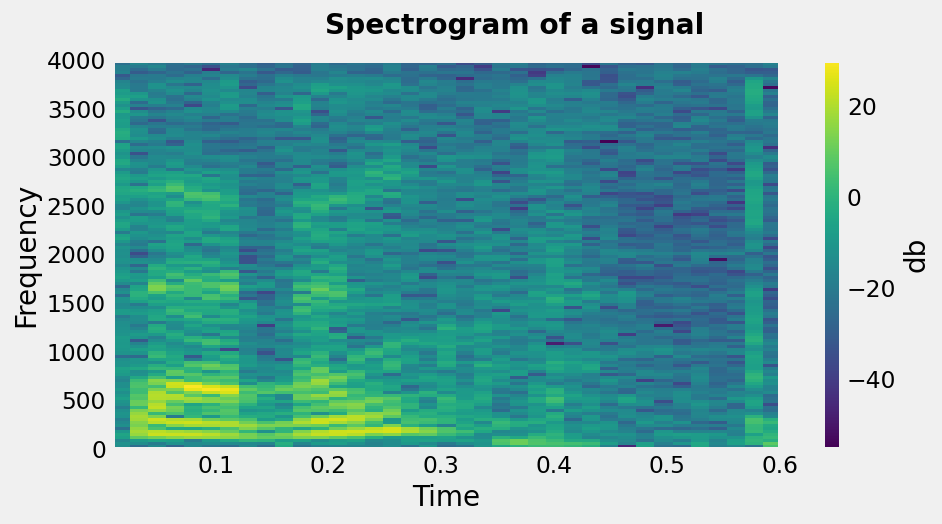

In [27]:
# Plot the spectrogram of power on log scale

# fig, ax = plt.subplots(figsize = (8,6))

powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(X[np.random.randint(100)], Fs=rate, scale = "dB")
cbar = plt.gcf().colorbar(imageAxis)
cbar.set_label('db')
plt.grid()
plt.suptitle("Spectrogram of a signal")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()   

In [28]:
def ft_mean_std(X, n, f_s = 8000):
    """Computes mean and std of each n x n block of spectrograms of X
       empty bins contains mean values of that column matrices
       
    Parameters:
        X: 2-d sampling array
        n: number of rows or columns to split spectogram
    Returns:
        A 2-d numpy array - feature Matrix with n x 2 x n features as columns
    """
    X_sp = [] #feature matrix
    for x in X:
        sp = power_to_db(melspectrogram(x, n_fft= len(x)), np.mean)
        x_sp = [] #current feature set
        # split the rows
        for v_split in np.array_split(sp, n, axis = 0):
            # split the columns
            for h_split in np.array_split(v_split, n, axis = 1):
                if h_split.size == 0: #happens when number of culumns < n
                    m = np.median(v_split).__round__(4)
                    sd = np.std(v_split).__round__(4)
                else:
                    m = np.mean(h_split).__round__(4)
                    sd = np.std(h_split).__round__(4)
                x_sp.extend([m,sd])
                
        X_sp.append(x_sp)

    return np.array(X_sp)

In [29]:
X_ft = ft_mean_std(X, 10)
len(X_ft)

3000

In [30]:
models = {
    "rfc": RFC(random_state=rs),
    "svm": Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC())])
}
scores = {}
for n in range(3,20,2):
    X_ft = ft_mean_std(X, n)
    X_train, X_test, y_train, y_test = train_test_split(X_ft, y, test_size = 0.20, random_state = rs)
    score = []
    for model in models:
        clf = models[model]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
        score.append((model, np.mean(f)))
    scores[n] = score

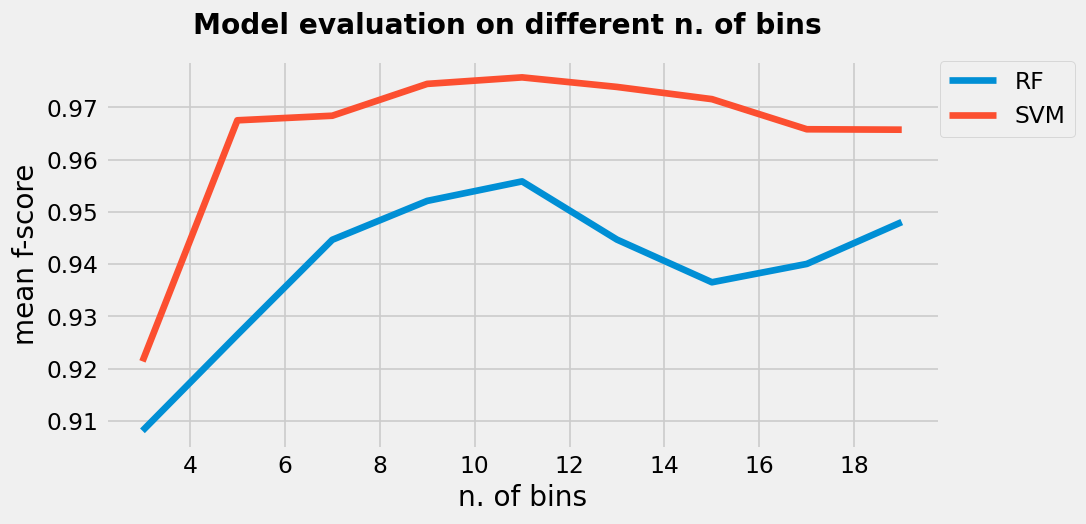

In [31]:
rf_scores = [x[0][1] for x in scores.values()]
svm_scores = [x[1][1] for x in scores.values()]
x = scores.keys()

plt.plot(x, rf_scores, label = 'RF')
plt.plot(x, svm_scores, label= 'SVM')

plt.legend(loc = (1,.8))
plt.suptitle("Model evaluation on different n. of bins")
plt.xlabel("n. of bins")
plt.ylabel('mean f-score')
plt.show()

In [32]:
X_ft = ft_mean_std(X, 10)
X_train, X_test, y_train, y_test = train_test_split(X_ft, y, test_size = 0.20, random_state = rs)

## Classification models

In [33]:
param_grid = {
    "n_estimators": [100,150,200],
    "criterion": ["gini", "entropy"],
    "min_impurity_decrease": [0.0,0.05,0.1]
}

clf = RFC(random_state = rs, n_jobs = -1 )
rf_search = GridSearchCV(clf, param_grid, scoring = "f1_macro", cv = 5)
rf_search.fit(X_train, y_train)

print("best Parameters for RF model:\n", rf_search.best_params_)
print("best score:", rf_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = rf_search.predict(X_test)
print(classification_report(y_test, y_pred))

best Parameters for RF model:
 {'criterion': 'gini', 'min_impurity_decrease': 0.0, 'n_estimators': 200}
best score: 0.9564969359099849


 Results on test dataset:


              precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       0.97      0.95      0.96        73
           2       0.98      0.93      0.96        58
           3       0.90      0.98      0.94        57
           4       0.97      1.00      0.99        68
           5       0.95      0.95      0.95        59
           6       0.90      0.85      0.87        52
           7       0.92      0.98      0.95        60
           8       0.95      0.92      0.93        62
           9       0.94      0.96      0.95        48

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



In [34]:
rfc = RFC(n_estimators= 200, criterion= 'gini', min_impurity_decrease= 0.0,random_state = rs, n_jobs = -1 )
scores = cross_val_score(rfc, X_ft, y, cv=10, scoring = 'accuracy', n_jobs = -1)
report = f"""Average accuracy of Random Forest model: {np.mean(scores):.2f}
with a standard deviation of {np.std(scores):.2f}
"""
print(report)

Average accuracy of Random Forest model: 0.96
with a standard deviation of 0.02



In [35]:
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC())]
pipeline = Pipeline(steps)

parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"]}
svm_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
svm_search.fit(X_train, y_train)

print("best Parameters for RF model:\n", svm_search.best_params_)
print("best score:", svm_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = svm_search.predict(X_test)
print(classification_report(y_test, y_pred))

best Parameters for RF model:
 {'SVM__C': 5, 'SVM__kernel': 'rbf'}
best score: 0.9816666666666667


 Results on test dataset:


              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.99      0.99      0.99        73
           2       0.98      0.97      0.97        58
           3       0.93      0.98      0.96        57
           4       1.00      1.00      1.00        68
           5       0.98      0.95      0.97        59
           6       0.98      0.96      0.97        52
           7       0.97      1.00      0.98        60
           8       1.00      0.97      0.98        62
           9       0.96      1.00      0.98        48

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



In [36]:
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC(C= 20, kernel= 'rbf'))]
pipeline = Pipeline(steps)
scores = cross_val_score(pipeline, X_ft, y, cv=10, scoring = 'accuracy', n_jobs = -1)
report = f"""Average accuracy of SVM model: {np.mean(scores):.2f}
with a standard deviation of {np.std(scores):.2f}
"""
print(report)

Average accuracy of SVM model: 0.99
with a standard deviation of 0.01



## Results

In [37]:
def split(array,w_bins):
    """Split a matrix into sub-matrices of equal size."""

    # original dimensions
    rows, cols = array.shape
    # size of sub matrices
    sub_rows = rows//w_bins + 1 * rows%w_bins
    sub_cols = cols//w_bins + 1 * cols%w_bins
    # padding to properly fit
    pad_rows = sub_rows*w_bins - rows
    pad_cols = sub_cols*w_bins - cols
    padded_array = np.pad(array, ((0,pad_rows), (0, pad_cols)))
    
    rows, cols = padded_array.shape
    return (padded_array.reshape(rows//sub_rows, sub_rows, -1, sub_cols)
                 .swapaxes(1, 2)
                 .reshape(-1, sub_rows, sub_cols))


def split_ft_mean_std(X, n):
    """ Computes mean and std of each n x n block of spectrograms of X
        bins are padded with zeros to equaly divide in n x n matrices.
        
    Parameters:
        X: 2-d sampling array
        n: number of rows or columns to split spectogram
    Returns:
        A 2-d numpy array - feature Matrix with n x n x 2 features
    """
    f_s = 8000
    X_sp = [] #feature matrix
    for x in X:
        sp = power_to_db(melspectrogram(x, n_fft= len(x)), np.mean)
        blocks = split(sp,n)
        mean = blocks.mean(axis = (-1,-2))
        std = blocks.std(axis = (-1,-2))
        X_sp.append(np.hstack((mean,std)))
    return np.array(X_sp)


In [38]:
%timeit -n2 -r1 ft_mean_std(X, 10)

1min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)


In [39]:
%timeit -n2 -r1 split_ft_mean_std(X, 10)

49.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)


In [40]:
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC())]
pipeline = Pipeline(steps)

parameteres = {'SVM__C':[5,10,20], 'SVM__kernel':["linear", "poly", "rbf"]}

In [41]:
X_ft = split_ft_mean_std(X, 10)
X_train, X_test, y_train, y_test = train_test_split(X_ft, y, test_size = 0.20, random_state = rs)

svm_search = GridSearchCV(pipeline, param_grid=parameteres, cv=5)
svm_search.fit(X_train, y_train)

print("best Parameters for RF model:\n", svm_search.best_params_)
print("best score:", svm_search.best_score_)
print("\n\n Results on test dataset:\n\n")
y_pred = svm_search.predict(X_test)
print(classification_report(y_test, y_pred))

best Parameters for RF model:
 {'SVM__C': 20, 'SVM__kernel': 'rbf'}
best score: 0.8941666666666667


 Results on test dataset:


              precision    recall  f1-score   support

           0       0.89      0.86      0.87        63
           1       0.94      0.86      0.90        73
           2       0.91      0.84      0.88        58
           3       0.79      0.84      0.81        57
           4       0.96      0.99      0.97        68
           5       0.85      0.88      0.87        59
           6       0.88      0.83      0.85        52
           7       0.87      0.88      0.88        60
           8       0.86      0.90      0.88        62
           9       0.78      0.83      0.81        48

    accuracy                           0.88       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.88      0.88      0.88       600



In [42]:
steps = [('scaler', StandardScaler()), ('SVM', svm.SVC(C= 20, kernel= 'rbf'))]
pipeline = Pipeline(steps)
scores = cross_val_score(pipeline, X_ft, y, cv=10, scoring = 'accuracy', n_jobs = -1)
report = f"""Average accuracy of SVM model: {np.mean(scores):.2f}
with a standard deviation of {np.std(scores):.2f}
"""
print(report)

Average accuracy of SVM model: 0.90
with a standard deviation of 0.01

